In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/'My Drive'/'Colab Notebooks'/
%ls

/content/drive/My Drive/Colab Notebooks
 EDA.ipynb                       summary12_right_C.csv
 equipment_A.csv                 summary12_right_D.csv
 equipment_B.csv                 summary15_A.csv
 equipment_C.csv                 summary15_B.csv
 equipment_D.csv                 summary15_C.csv
 index_master.csv                summary15_D.csv
 intercept_days_A.csv            summary18_A.csv
 intercept_days_B.csv            summary18_B.csv
 intercept_days_C.csv            summary18_C.csv
 intercept_days_D.csv            summary18_D.csv
'model1 (1).ipynb'               summary19_A.csv
'model1 (1).ipynb のコピー'      summary19_B.csv
 model11.ipynb                   summary19_C.csv
 model12.ipynb                   summary19_D.csv
 model12_refine_CD.ipynb         summary20_C.csv
 model12_refine.ipynb            summary21_A.csv
 model12_refine_level_CD.ipynb   summary21_B.csv
 model12_refine_level.ipynb      summary21_C.csv
 model12_refine_right_CD.ipynb   summary21_D.csv
 model12_refine_righ

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
tracks={}
for no in ['A','B','C','D']:
    tracks[no] = pd.read_csv("track_" + no + ".csv",
                             usecols=['date', 'キロ程', '高低左'],
                             parse_dates=["date"])

In [0]:
import datetime
from tqdm import tqdm
import random
import sys

In [0]:
def get_day(dates):
    day = [(date - datetime.datetime(2017, 4, 1)).days for date in dates]
    return np.array(day)

In [0]:
def feature_engineering(df, dmm, mv, admm):
    if dmm:
         df['diff_moving_mean'] = df['高低左'] - df['高低左'].rolling(window=7, min_periods=1, center=True).median()
    if mv:
        df['moving_variance'] = df['高低左'].rolling(window=7, min_periods=1, center=True).kurt()
    if admm:
        df['accumulation_diff_moving_mean'] = np.cumsum(
            abs(df['高低左'].rolling(window=3, min_periods=1, center=True).median() -
                df['高低左'].rolling(window=15, min_periods=1, center=False).median()))
    return df

In [0]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [0]:
def scaling(df, w1, w2, w3, w4):
    df['day'] = ss.fit_transform(df['day'].astype(float).values.reshape(len(df), 1))
    if w1 != 0:
        df['高低左'] = ss.fit_transform(df['高低左'].values.reshape(len(df), 1))*w1
    if w2 != 0:
        df['diff_moving_mean'] = ss.fit_transform(df['diff_moving_mean'].values.reshape(len(df), 1))*w2
    if w3 != 0:
        df['moving_variance'] = df['moving_variance'].fillna(0) #rollingした高低左が全部同じ値のときはNANになる
        df['moving_variance'] = ss.fit_transform(df['moving_variance'].values.reshape(len(df), 1))*w3
    if w4 != 0:
        df['accumulation_diff_moving_mean'] = \
        ss.fit_transform(df['accumulation_diff_moving_mean'].values.reshape(len(df), 1))*w4
    return df

In [0]:
from sklearn.neighbors import KernelDensity
bandwidth = [0.1, 1, 10, 50, 100]
kernel = ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
metric = ['minkowski', 'cityblock', 'cosine', 'euclidean', 'l1', 'l2', 'manhattan']
leaf_size = [10, 40, 400, 4000]
kd = KernelDensity(bandwidth=bandwidth[3], kernel=kernel[0], metric=metric[0], leaf_size=leaf_size[1])

In [0]:
def kd_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99999, False, True)].index.values
    return normal_id

In [0]:
def kd_outliers1(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.999, False, True)].index.values
    return normal_id

In [0]:
def kd_outliers2(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99998, False, True)].index.values
    return normal_id

In [0]:
from scipy.cluster.hierarchy import linkage, fcluster

In [0]:
def dendrogram_outliers(raw):
    df = raw.copy()
    df = feature_engineering(df, True, False, True)
    df = scaling(df, 10, 50, 0, 100)

    linkage_result = linkage(df, method='ward', metric='euclidean')
    threshold = 0.95 * np.max(linkage_result[:, 2])
    clustered = fcluster(linkage_result, threshold, criterion='distance')

    df['label'] = clustered
    normal_label = df['label'].mode()[0]
    normal_id = df[df['label'] == normal_label].index.values
    return normal_id

In [0]:
def remove_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])
    return local_global[3][1]

def flag_outliers(raw):
    local_global = [[[], []], [[], []], [[], []], [[], []]]
    local_global[0][1].extend(raw.index.values)
    df1 = raw.copy()
    local_global[1][1].extend(kd_outliers(df1))

    df2 = raw.loc[local_global[1][1]]
    df2 = df2.reset_index(drop=True)
    local_global[2][0].extend(dendrogram_outliers(df2))
    local_global[2][1].extend([local_global[1][1][i] for i in local_global[2][0]])

    df3 = raw.loc[local_global[2][1]]
    df3 = df3.reset_index(drop=True)
    local_global[3][0].extend(kd_outliers2(df3))
    local_global[3][1].extend([local_global[2][1][i] for i in local_global[3][0]])

    out1 = set(local_global[0][1]) - set(local_global[1][1])
    out2 = set(local_global[1][1]) - set(local_global[2][1])
    out3 = set(local_global[2][1]) - set(local_global[3][1])
    normal = local_global[3][1]
    return out1, out2, out3, normal

fig, axes = plt.subplots(50, 1, figsize=(15, 100), sharex=True)
random.seed(110)
track = tracks['C']
kilos = track['キロ程'].unique()

for i, kilo in enumerate(random.sample(list(kilos), 50)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    if len(data) < 20:
        print(i)
        continue
    out1, out2, out3, normal = flag_outliers(data)

    datao1 = data.loc[out1]
    datao2 = data.loc[out2]
    datao3 = data.loc[out3]
    datal = data.loc[normal]

    axes[i].plot(datao1['day'], datao1['高低左'], marker='.', linewidth=0, c='c')
    axes[i].plot(datao2['day'], datao2['高低左'], marker='.', linewidth=0, c='g')
    axes[i].plot(datao3['day'], datao3['高低左'], marker='.', linewidth=0, c='r')
    axes[i].plot(datal['day'], datal['高低左'], marker='.', linewidth=0, c='b')

In [0]:
def get_intercept(raw):
    data = raw.copy()
    if sum(data['date'] >= "2018-03-01") == 0:
#        print('sum(data["date"] >= "2018-03-01") == 0')
        intercept = np.median(data['高低左'].values[-10:])

    else:
        data = data.loc[data['date'] >= "2018-03-01"]
        data = data.reset_index(drop=True)
        data = data.drop('date', axis=1)
        if len(data) < 5:
 #           print('sum(data["date"] >= "2018-03-01") < 4')
            intercept = np.median(data['高低左'].values)

        else:
            normal_id = kd_outliers1(data)
            data = data.loc[normal_id]
            intercept = np.median(data['高低左'].values)

    return intercept

In [0]:
summarys12_left = {}
for no in ['A', 'B', 'C', 'D']:
    summarys12_left[no] = pd.read_csv(f'summary12_refine_{no}.csv', index_col=0)

In [0]:
summarys12_right = {}
for no in ['A', 'B', 'C', 'D']:
    summarys12_right[no] = pd.read_csv(f'summary12_right_{no}.csv', usecols=['傾き'])

In [0]:
summarys4_left = {}
for no in ['A', 'B', 'C', 'D']:
    summarys4_left[no] = pd.read_csv(f'summary4_refine_{no}.csv', usecols=['傾き'])

In [0]:
summarys4_right = {}
for no in ['A', 'B', 'C', 'D']:
    summarys4_right[no] = pd.read_csv(f'summary4_refine_right_{no}.csv', usecols=['傾き'])

In [0]:
summarys5_left = {}
for no in ['A', 'B', 'C', 'D']:
    summarys5_left[no] = pd.read_csv(f'summary5_refine_{no}.csv', usecols=['傾き'])

In [0]:
summarys5_right = {}
for no in ['A', 'B', 'C', 'D']:
    summarys5_right[no] = pd.read_csv(f'summary5_refine_right_{no}.csv', usecols=['傾き'])

In [0]:
for no in ['A', 'B', 'C', 'D']:
    summarys12_left[no].loc[summarys12_left[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys12_left[no].loc[summarys12_left[no]['傾き'].notnull(), '傾き'])
    summarys12_left[no].loc[summarys12_left[no]['分散比'] == 100, '分散比'] = \
    np.median(summarys12_left[no].loc[summarys12_left[no]['分散比'].notnull(), '分散比'])
    summarys12_left[no].loc[summarys12_left[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys12_left[no].loc[summarys12_left[no]['傾き'].notnull(), '傾き'])
    summarys12_left[no].loc[summarys12_left[no]['切片'].isnull(), '切片'] = \
    np.median(summarys12_left[no].loc[summarys12_left[no]['切片'].notnull(), '切片'])

In [0]:
for no in ['A', 'B', 'C', 'D']:
    summarys12_right[no].loc[summarys12_right[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys12_right[no].loc[summarys12_right[no]['傾き'].notnull(), '傾き'])
    summarys12_right[no].loc[summarys12_right[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys12_right[no].loc[summarys12_right[no]['傾き'].notnull(), '傾き'])

In [0]:
for no in ['A', 'B', 'C', 'D']:
    summarys4_left[no].loc[summarys4_left[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys4_left[no].loc[summarys4_left[no]['傾き'].notnull(), '傾き'])
    summarys4_left[no].loc[summarys4_left[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys4_left[no].loc[summarys4_left[no]['傾き'].notnull(), '傾き'])

In [0]:
for no in ['A', 'B', 'C', 'D']:
    summarys4_right[no].loc[summarys4_right[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys4_right[no].loc[summarys4_right[no]['傾き'].notnull(), '傾き'])
    summarys4_right[no].loc[summarys4_right[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys4_right[no].loc[summarys4_right[no]['傾き'].notnull(), '傾き'])

In [0]:
for no in ['A', 'B', 'C', 'D']:
    summarys5_left[no].loc[summarys5_left[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys5_left[no].loc[summarys5_left[no]['傾き'].notnull(), '傾き'])
    summarys5_left[no].loc[summarys5_left[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys5_left[no].loc[summarys5_left[no]['傾き'].notnull(), '傾き'])

In [0]:
for no in ['A', 'B', 'C', 'D']:
    summarys5_right[no].loc[summarys5_right[no]['傾き'] == 100, '傾き'] = \
    np.median(summarys5_right[no].loc[summarys5_right[no]['傾き'].notnull(), '傾き'])
    summarys5_right[no].loc[summarys5_right[no]['傾き'].isnull(), '傾き'] = \
    np.median(summarys5_right[no].loc[summarys5_right[no]['傾き'].notnull(), '傾き'])

In [0]:
from lightgbm import LGBMRegressor
lgb = LGBMRegressor()

In [0]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys12_left[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys12_left[no]['傾き_lgbm'] = train_pred

In [0]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys12_right[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys12_right[no]['傾き_lgbm'] = train_pred

In [0]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys4_left[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys4_left[no]['傾き_lgbm'] = train_pred

In [0]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys4_right[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys4_right[no]['傾き_lgbm'] = train_pred

In [0]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys5_left[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys5_left[no]['傾き_lgbm'] = train_pred

In [0]:
for no in ['A', 'B', 'C', 'D']:
    train = pd.DataFrame(summarys5_right[no]['傾き'].copy())
    for i in range(30):
        train[f'lag{i+1}'] = train['傾き'].shift(i+1)

    X_train = train.drop(['傾き'], axis=1).values
    y_train = train['傾き'].values
    lgb.fit(X_train, y_train)
    train_pred = lgb.predict(X_train)
    summarys5_right[no]['傾き_lgbm'] = train_pred

In [0]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = summarys12_left[no].drop(['分散比', '測定回数', 'データ数'], axis=1)
    summarys[no]['傾き12右'] = summarys12_right[no]['傾き']
    summarys[no]['傾き12右_lgbm'] = summarys12_right[no]['傾き_lgbm']
    summarys[no]['傾き4左'] = summarys4_left[no]['傾き']
    summarys[no]['傾き4左_lgbm'] = summarys4_left[no]['傾き_lgbm']
    summarys[no]['傾き4右'] = summarys4_right[no]['傾き']
    summarys[no]['傾き4右_lgbm'] = summarys4_right[no]['傾き_lgbm']
    summarys[no]['傾き5左'] = summarys5_left[no]['傾き']
    summarys[no]['傾き5左_lgbm'] = summarys5_left[no]['傾き_lgbm']
    summarys[no]['傾き5右'] = summarys5_right[no]['傾き']
    summarys[no]['傾き5右_lgbm'] = summarys5_right[no]['傾き_lgbm']

In [0]:
del summarys12_left, summarys12_right, summarys4_left, summarys4_right, summarys5_left, summarys5_right

In [0]:
from sklearn.metrics import mean_absolute_error

In [46]:
for no in tqdm(['A', 'B', 'D']):
    track = tracks[no]
    summary = summarys[no]
    summary['傾き_best'] = 0.
    kilos = summary['キロ程'].values#[:10]
#    for kilo in tqdm(kilos):
    for kilo in kilos:
        if kilo%1000 == 0:
            print(kilo)
        data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
        data = data.dropna()
        data = data.reset_index(drop=True)
        data['day'] = get_day(data['date'])
        data = data.drop(['date'], axis=1)
        slopes = summary.loc[summary['キロ程'] == kilo]
        slopes = slopes.drop(['路線', 'キロ程', '切片'], axis=1).values[0]
        slopes = slopes[::-1]
        errors = np.zeros_like(slopes)
        for i in range(4):
            tmp = data.loc[data['day'] >= i*91]
            tmp = tmp.loc[tmp['day'] < (i+1)*91]
            tmp = tmp.reset_index(drop=True)
            if len(tmp) < 5:
                continue
            normal_id = kd_outliers3(tmp)
            tmp = tmp.loc[normal_id]
            tmp = tmp.reset_index(drop=True)
            if len(tmp) < 5:
                continue
            normal_id = kd_outliers3(tmp)
            tmp = tmp.loc[normal_id]
            tmp = tmp.reset_index(drop=True)
            if len(tmp) < 5:
                continue
            intercept = np.median(tmp['高低左'].values)
            intercept_day = np.median(tmp['day'].values)
            for j, slope in enumerate(slopes):
                errors[j] += mean_absolute_error(tmp['高低左'].values,
                                                 [intercept + (day-intercept_day)*slope for day in tmp['day'].values])
        summary.loc[summary['キロ程'] == kilo, '傾き_best'] = slopes[np.argmin(errors)]
    summary.to_csv(f'summary23_{no}.csv')



  0%|          | 0/3 [00:00<?, ?it/s]

10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000




 33%|███▎      | 1/3 [1:18:57<2:37:54, 4737.34s/it]

10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000




 67%|██████▋   | 2/3 [2:17:17<1:12:46, 4366.05s/it]

10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000




100%|██████████| 3/3 [2:57:13<00:00, 3775.17s/it]  



In [0]:
def kd_outliers3(raw):
    df = raw.copy()
    df = feature_engineering(df, True, True, True)
    df = scaling(df, 50, 50, 0.5, 50)
    kd.fit(df)
    score_pred = kd.score_samples(df)
#    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.99, False, True)].index.values
    normal_id = df[np.where(score_pred <= np.average(score_pred)*0.999, False, True)].index.values
    return normal_id

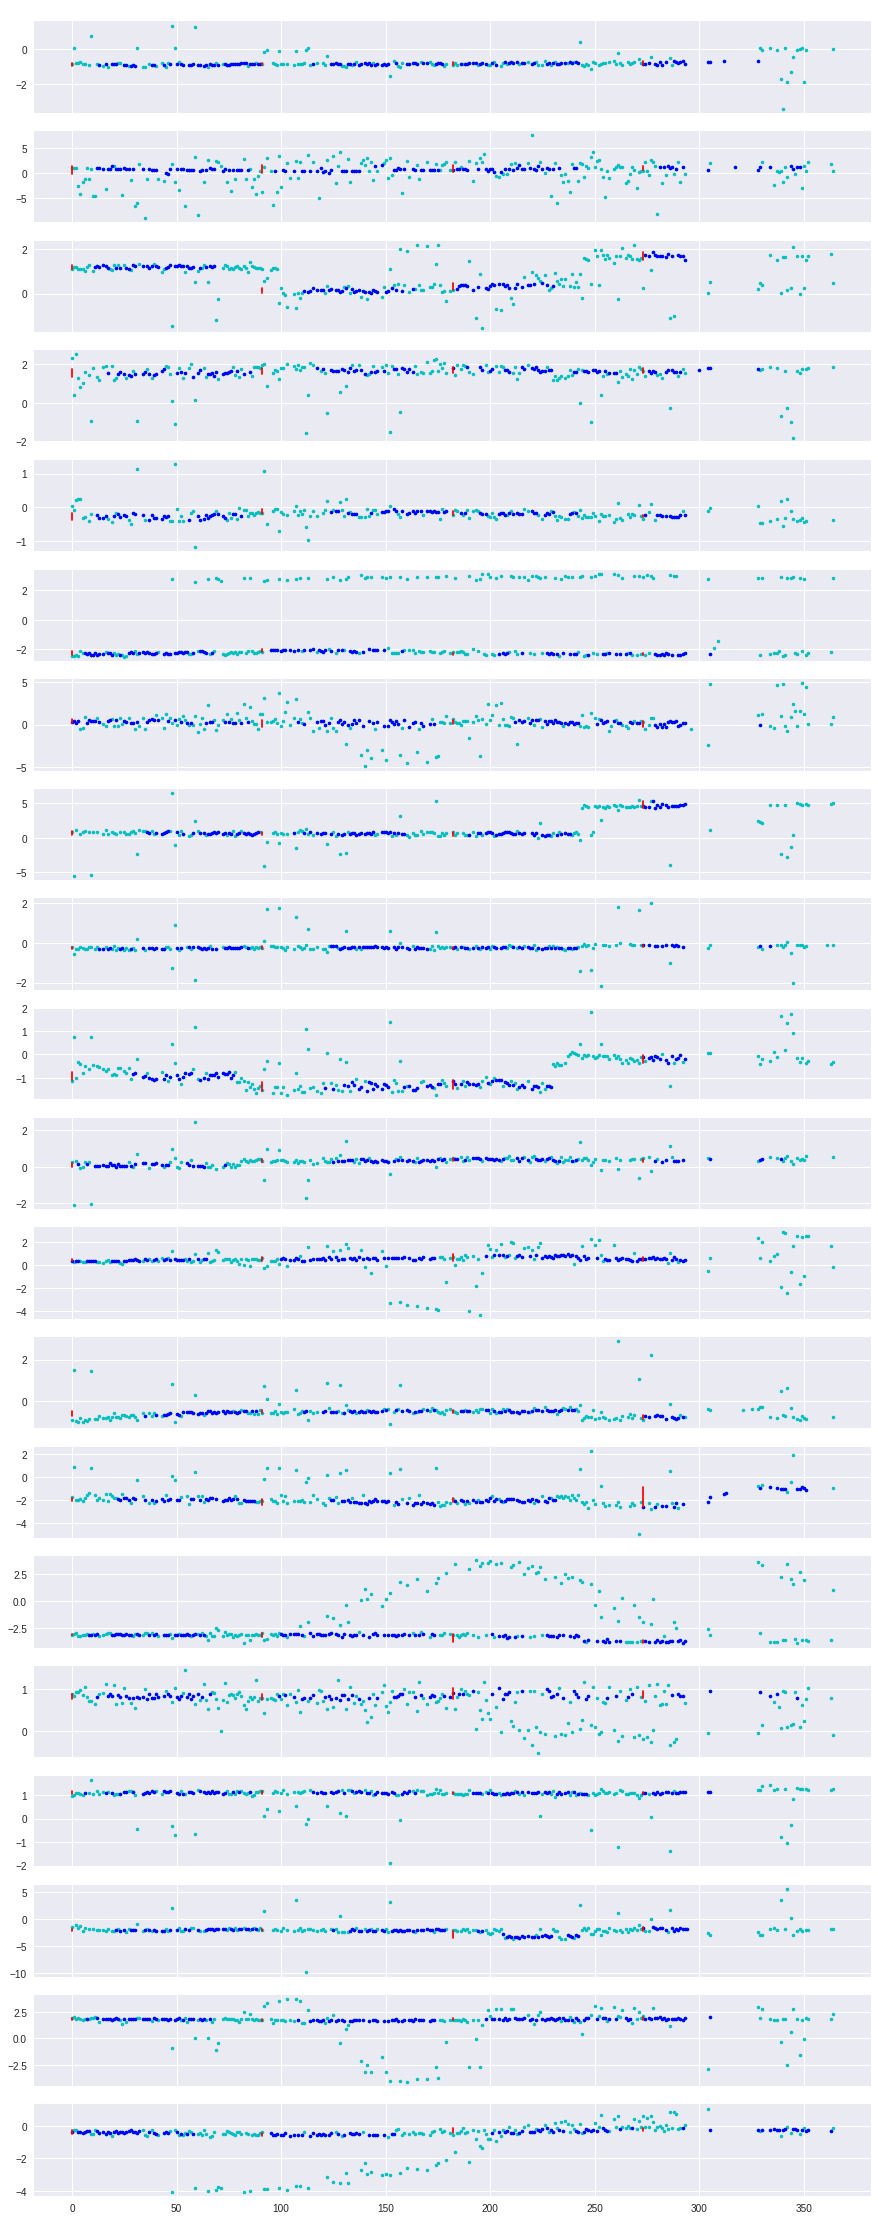

In [45]:
random.seed(10)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['A']
#kilos = track['キロ程'].unique()[:20]
kilos = track['キロ程'].unique()
kilos = random.sample(list(kilos), 20)
for i, kilo in enumerate(kilos):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    for j in range(4):
        tmp = data.loc[data['day'] >= j*91]
        tmp = tmp.loc[tmp['day'] < (j+1)*91]
        tmp = tmp.reset_index(drop=True)
        if len(tmp) < 5:
            continue
#        normal_id = remove_outliers(tmp)
#        normal_id = dendrogram_outliers(tmp)
        normal_id = kd_outliers3(tmp)
        tmp = tmp.loc[normal_id]
        normal_id = kd_outliers3(tmp)
        tmp = tmp.loc[normal_id]
        axes[i].plot(tmp['day'], tmp['高低左'], marker='.', linewidth=0, c='b')
        axes[i].plot([j*91, j*91], [min(tmp['高低左']), max(tmp['高低左'])],  c='r')

    axes[i].set_title(f'kilo: {kilo}', color='w')

In [0]:
summarys['A'][:20]

,路線,キロ程,傾き,切片,傾き_lgbm,傾き12右,傾き12右_lgbm,傾き4左,傾き4左_lgbm,傾き4右,傾き4右_lgbm,傾き5左,傾き5左_lgbm,傾き5右,傾き5右_lgbm,傾き_best
0,A,10000,-0.003068,0.375,-0.002667,0.000899,0.000735,-0.002227,-0.001902,-0.000478,0.000016,-0.004349,-0.005217,0.000528,-0.000701,-0.000701
1,A,10001,-0.002222,2.680,-0.002633,0.000167,0.000860,-0.001725,-0.001831,0.000215,0.000435,-0.002332,-0.003880,-0.004745,-0.002868,0.000000
2,A,10002,-0.003626,5.005,-0.002861,0.000166,0.000596,-0.002314,-0.002184,0.000483,0.000501,-0.009613,-0.006428,0.000105,0.000298,0.000596
3,A,10003,0.000199,5.955,-0.000581,0.002050,0.001178,-0.002464,-0.001986,0.001061,0.000547,-0.000816,-0.002460,0.004835,0.002837,0.002050
4,A,10004,0.002985,5.000,0.002258,0.002450,0.002056,-0.000732,-0.000564,0.001321,0.001634,0.002342,0.001434,0.002930,0.003851,0.003851
5,A,10005,0.000586,1.645,0.001974,0.003076,0.003341,0.000105,0.000055,0.003380,0.002133,-0.004209,-0.003445,0.003121,0.003312,0.003380
6,A,10006,-0.000215,-3.175,0.000671,0.005963,0.004592,0.002266,0.001514,0.007386,0.006269,-0.003520,-0.001528,0.003897,0.003723,0.003897
7,A,10007,0.003765,-7.135,0.001227,0.003947,0.004555,0.002468,0.002492,0.004384,0.004272,0.007349,0.004144,0.007831,0.005339,0.003765
8,A,10008,0.001148,-8.850,0.000996,0.002785,0.003207,0.001612,0.001308,0.000820,0.001256,0.001929,0.002280,0.001691,0.002349,0.000820
9,A,10009,-0.001019,-7.410,-0.000751,-0.002543,-0.001384,-0.000989,0.000016,-0.002942,-0.002151,-0.001995,-0.001753,-0.003636,-0.001734,0.000000


In [0]:
summarys = {}
for no in ['A', 'B', 'C', 'D']:
    summarys[no] = pd.read_csv(f'summary23_{no}.csv', index_col=0)

In [0]:
p = []
intercept_day = 15
for no in ['A', 'B', 'C', 'D']:
    summary = summarys[no]
    for i in range(91):
        day = summary['切片'].values + summary['傾き_best'].values*(i+intercept_day)
        p.extend(day)

submision = pd.DataFrame(p)
print(sum(submision.isnull()))
submision = submision.fillna(0)
submision = submision.apply(lambda x:x.round(2)) #サイズが大きいため予測値を桁落とし

0


In [0]:
def get_intercept_day(raw):
    data = raw.copy()
    if sum(data['date'] >= "2018-03-01") == 0:
#        print('sum(data["date"] >= "2018-03-01") == 0')
#        intercept_day = np.median(data['day'].values[-10:])
        intercept_day = 334 #=(datetime.datetime(2018, 3, 1) - datetime.datetime(2017, 4, 1)).days #inter2!!!

    else:
        data = data.loc[data['date'] >= "2018-03-01"]
        data = data.reset_index(drop=True)
        data = data.drop('date', axis=1)
        if len(data) < 5:
#            print('sum(data["date"] >= "2018-03-01") < 5')
            intercept_day = np.median(data['day'].values)

        else:
            normal_id = kd_outliers1(data)
            data = data.loc[normal_id]
            if len(data) == 0:
                print('hoge piyo fugafuga')
                intercept_day = 334
            else:
                intercept_day = np.median(data['day'].values)

    return intercept_day

In [58]:
p = []
for no in tqdm(['A', 'B', 'C', 'D']):
    summary = summarys[no]#[:10]

    track = tracks[no]
    track = track.dropna(subset=['高低左'])
    track = track.reset_index(drop=True)
    intercept_days = []
    kilos = summary['キロ程'].unique()#[:10]
    for kilo in kilos:
#    for kilo in tqdm(kilos):
        if kilo%1000 == 0:
            print(kilo)
        data = track.loc[track['キロ程'] == kilo]
        data = data.reset_index(drop=True)
        data['day'] = get_day(data['date'])
        intercept_day = get_intercept_day(data)
        intercept_days.append(intercept_day)
    inter_df = pd.DataFrame(data=intercept_days)
    inter_df.to_csv(f'intercept_days_{no}.csv')

    for i in range(91):
        day = summary['切片'].values + summary['傾き_best'].values*(i+365-np.array(intercept_days))
        p.extend(day)

submision = pd.DataFrame(p)
print(sum(submision.isnull()))
submision = submision.fillna(0)
submision = submision.apply(lambda x:x.round(2)) #サイズが大きいため予測値を桁落とし






  0%|          | 0/4 [00:00<?, ?it/s]

10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000







 25%|██▌       | 1/4 [12:42<38:06, 762.00s/it]

10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000







 50%|█████     | 2/4 [20:05<22:13, 666.58s/it]

10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000







 75%|███████▌  | 3/4 [49:10<16:29, 989.99s/it]

10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000







100%|██████████| 4/4 [54:21<00:00, 786.42s/it]






0


In [59]:
submision.max()

0    19.42
dtype: float64

In [60]:
submision.min()

0   -19.39
dtype: float64

submision.loc[submision[0] > 16, 0] = 16
submision.loc[submision[0] < -16, 0] = -16

In [61]:
len(submision[submision[0] >= 16])
len(submision[submision[0] <= -16])

816

In [62]:
submision

,0
0,0.36
1,2.68
2,5.02
3,5.99
4,5.07
5,1.71
6,-3.09
7,-7.06
8,-8.83
9,-7.41


In [0]:
submision.to_csv("submit23.csv", header=None)

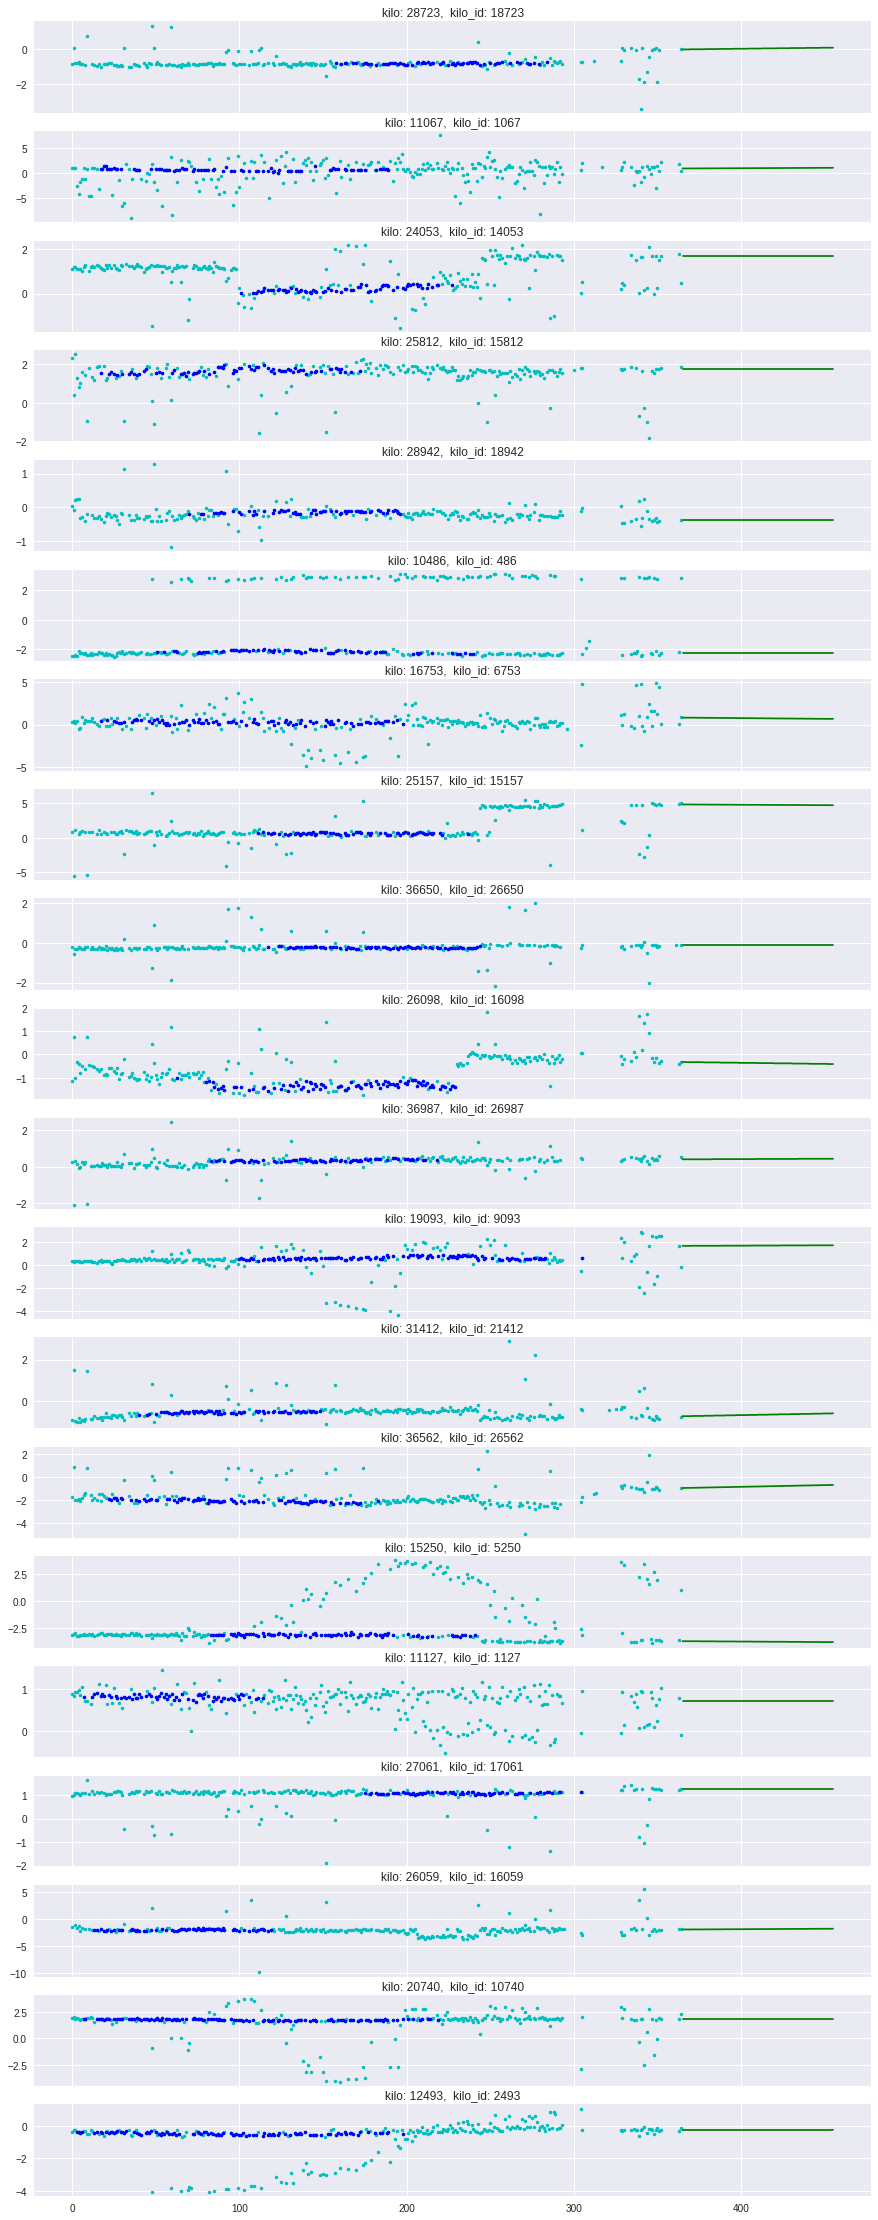

In [64]:
random.seed(10)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['A']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

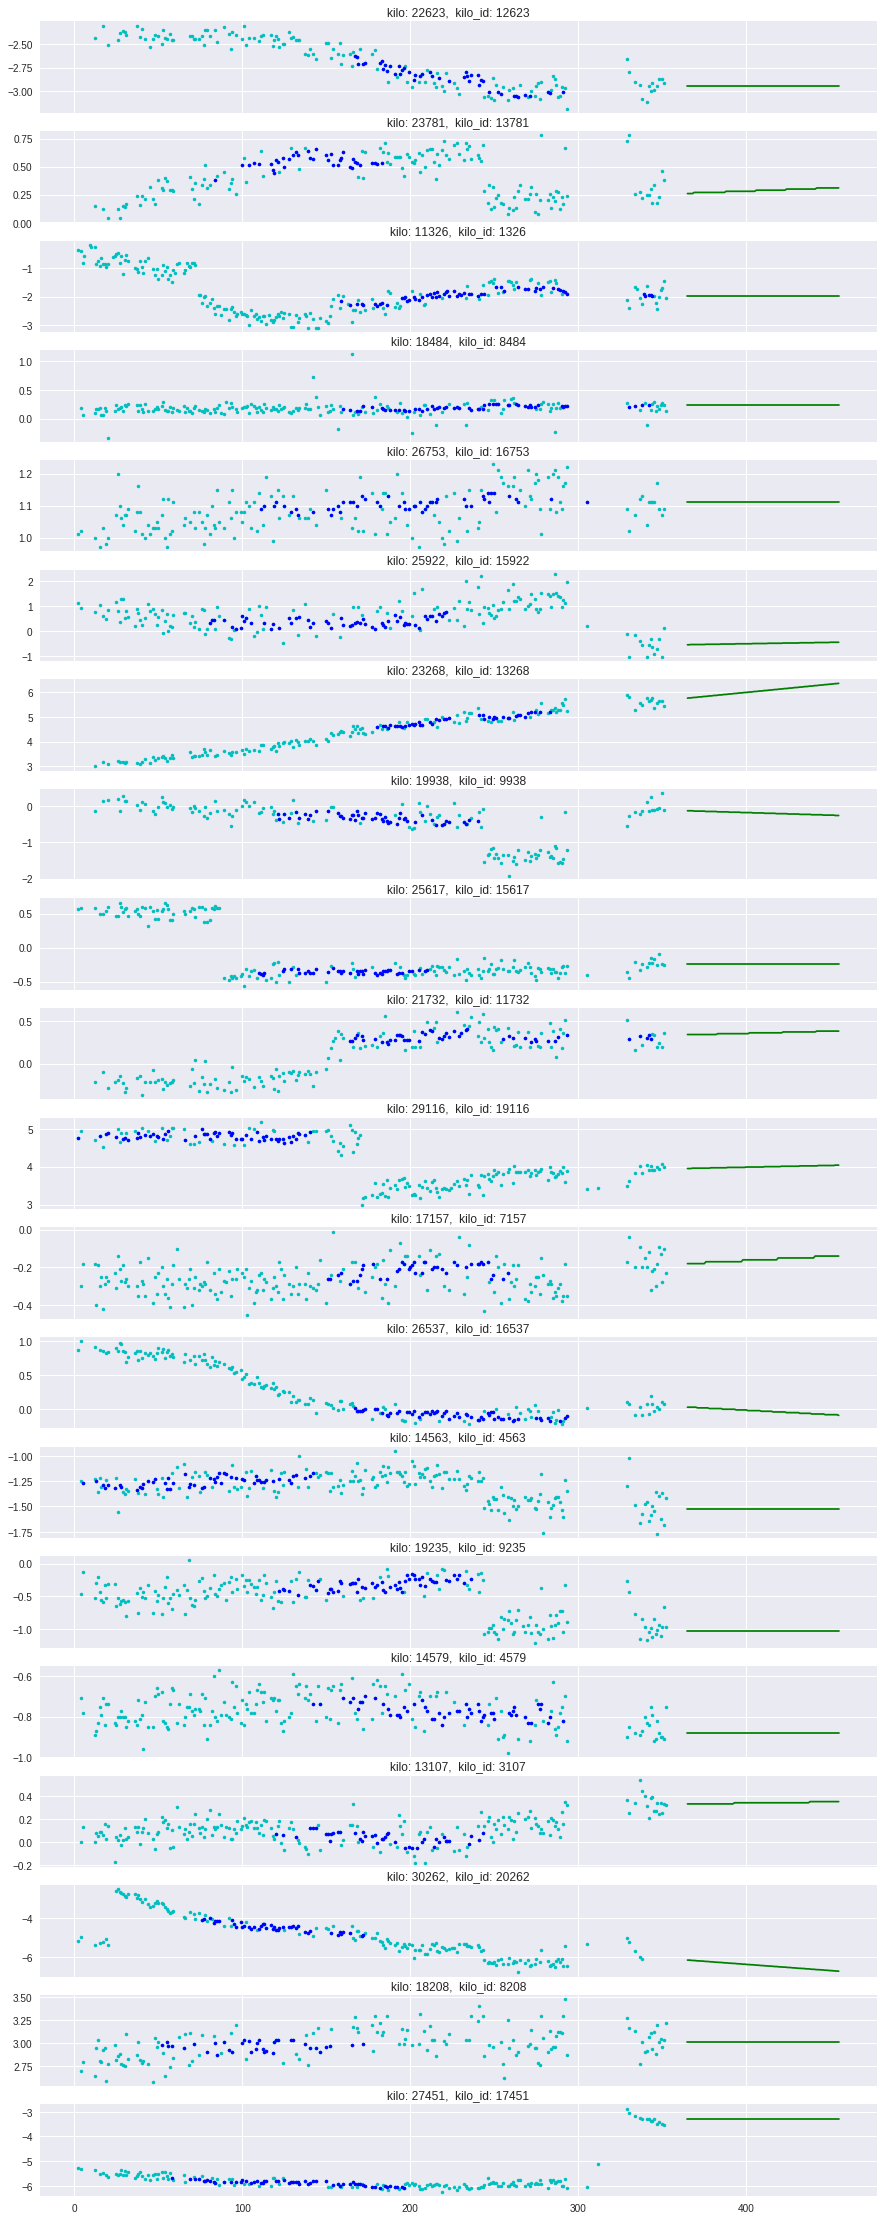

In [65]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['B']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

In [0]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['C']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')

In [0]:
random.seed(0)

fig, axes = plt.subplots(20, 1, figsize=(15, 40), sharex=True)

track = tracks['D']
kilos = track['キロ程'].unique()
for i, kilo in enumerate(random.sample(list(kilos), 20)):
    data = track.loc[track['キロ程'] == kilo, ['date', '高低左']]
    data = data.dropna(subset=['高低左'])
    data = data.reset_index(drop=True)
    data['day'] = get_day(data['date'])
    data = data.drop(['date'], axis=1)
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='c')

    kilo_id = kilo - 10000
    hoge = [kilo_id + i*len(kilos) for i in range(91)]
    hoge = np.array(hoge) + len(tracks['A']['キロ程'].unique())*91 + len(tracks['B']['キロ程'].unique())*91 + len(tracks['C']['キロ程'].unique())*91
    piyo = submision.loc[hoge, 0]
    axes[i].plot(range(365, 365 + 91), piyo, c='g')

    normal_id = remove_outliers(data)
    data = data.loc[normal_id]
    axes[i].plot(data['day'], data['高低左'], marker='.', linewidth=0, c='b')

    axes[i].set_title(f'kilo: {kilo},  kilo_id: {kilo_id}')